# Mushroom Edibility Prediction — Jupyter Notebook

> **Author:** Dhruv (with ML mentor)
>
> **Goal:** Build a classification model (edible vs poisonous). Clean pipeline, EDA visualizations, encoding, Decision Tree baseline, Random Forest final model, feature importance, model saving, and prediction function.

## 1. Setup (run once)

In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

## 2. Load data

In [2]:
df = pd.read_csv('mushroom.csv')
print(df.shape)
df.head()

(61069, 21)


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


## 3. Quick info & missing values

In [3]:
# Basic info
print(df.info())

# Missing value counts and percent
missing_count = df.isnull().sum()
missing_percent = (df.isnull().mean() * 100).sort_values(ascending=False)
missing_summary = pd.concat([missing_count, missing_percent], axis=1, keys=['missing_count', 'missing_percent'])
missing_summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

,missing_count,missing_percent
class,0,0.000000
cap-diameter,0,0.000000
cap-shape,0,0.000000
cap-surface,14120,23.121387
cap-color,0,0.000000
does-bruise-or-bleed,0,0.000000
gill-attachment,9884,16.184971
gill-spacing,25063,41.040462
gill-color,0,0.000000
stem-height,0,0.000000


**Markdown note:** If you see columns with very high missing percentages (>40%), we'll drop them next.

## 4. Visualize missing values (quick)

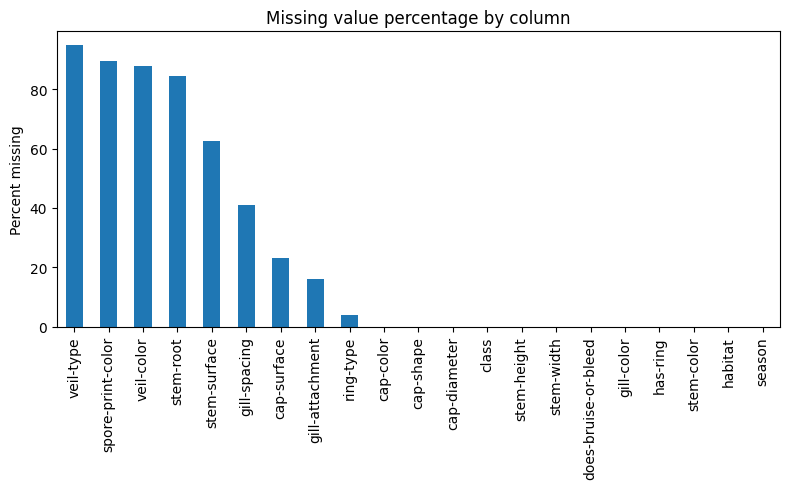

In [4]:
plt.figure(figsize=(8,5))
missing_percent.plot(kind='bar')
plt.title('Missing value percentage by column')
plt.ylabel('Percent missing')
plt.tight_layout()
plt.show()

## 5. Drop extremely missing columns (recommended)

In [5]:
cols_to_drop = [
    'cap-surface',
    'gill-attachment',
    'gill-spacing',
    'stem-root',
    'stem-surface',
    'veil-type',
    'veil-color',
    'spore-print-color'
]

# Drop only if present (safe to re-run)
cols_to_drop = [c for c in cols_to_drop if c in df.columns]

df = df.drop(columns=cols_to_drop)
print('New shape:', df.shape)

New shape: (61069, 13)


## 6. Target distribution (class balance)

class
p    33888
e    27181
Name: count, dtype: int64


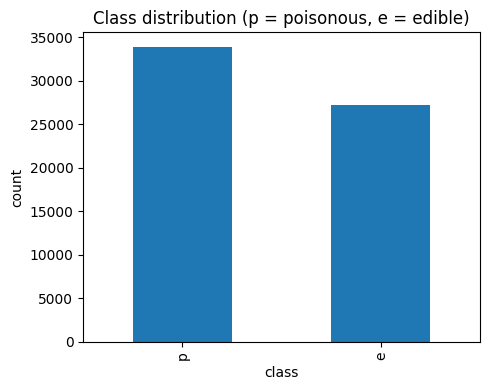

In [6]:
print(df['class'].value_counts())

plt.figure(figsize=(5,4))
df['class'].value_counts().plot(kind='bar')
plt.title('Class distribution (p = poisonous, e = edible)')
plt.xlabel('class')
plt.ylabel('count')
plt.tight_layout()
plt.show()

*This plot shows the percentage of missing values in each column. Columns with extremely high missing values (>40%) were removed to improve data quality and model performance.*

## 7. Basic EDA: numeric features

In [7]:
# Show summary stats for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns:', num_cols)

df[num_cols].describe()

Numeric columns: ['cap-diameter', 'stem-height', 'stem-width']


,cap-diameter,stem-height,stem-width
count,61069.000000,61069.000000,61069.000000
mean,6.733854,6.581538,12.149410
std,5.264845,3.370017,10.035955
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.210000
50%,5.860000,5.950000,10.190000
75%,8.540000,7.740000,16.570000
max,62.340000,33.920000,103.910000


### 7.1 Histograms

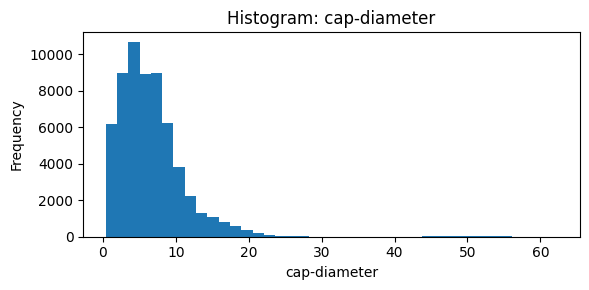

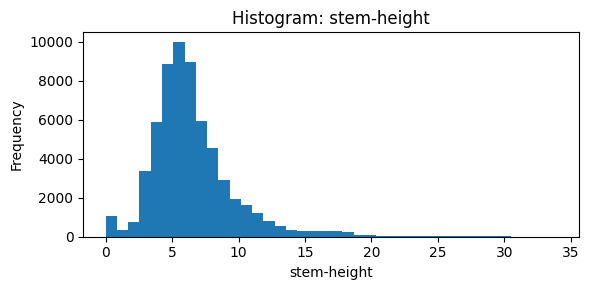

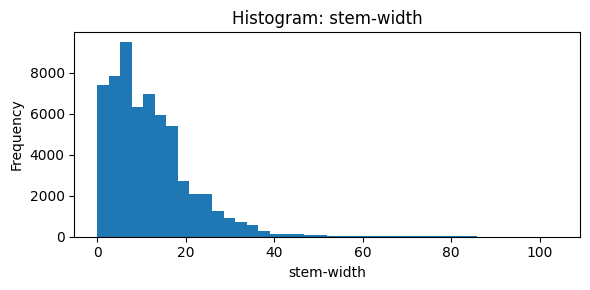

In [8]:
for col in num_cols:
    plt.figure(figsize=(6,3))
    plt.hist(df[col].dropna(), bins=40)
    plt.title(f'Histogram: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

*All three numeric features cap-diameter, stem-height, and stem-width, show right-skewed distributions with a majority of observations in low-to-mid ranges and a few large outliers. These numeric patterns help the model differentiate mushroom types effectively.*

### 7.2 Boxplots (to inspect outliers)

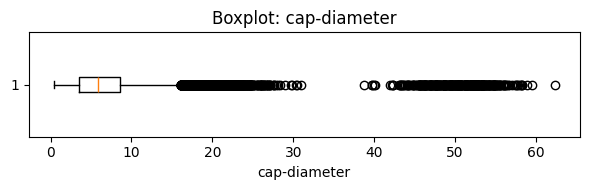

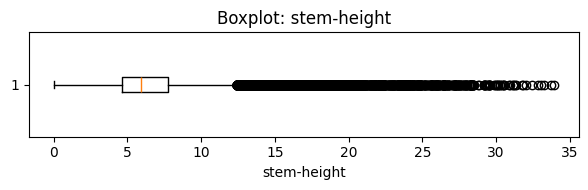

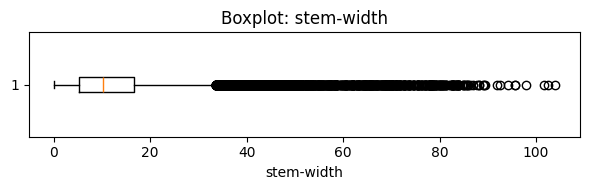

In [9]:
for col in num_cols:
    plt.figure(figsize=(6,2))
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f'Boxplot: {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

*All three numeric boxplots show right-skewness and natural high-end outliers. These patterns confirm diversity in mushroom sizes and support the importance of numeric features in the classification model.*

## 8. Categorical feature overview (counts)

In [10]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols.remove('class')

# Show top categories for each cat column
for col in cat_cols:
    print('\n', col, df[col].value_counts().head())


 cap-shape cap-shape
x    26934
f    13404
s     7164
b     5694
o     3460
Name: count, dtype: int64

 cap-color cap-color
n    24218
y     8543
w     7666
g     4420
e     4035
Name: count, dtype: int64

 does-bruise-or-bleed does-bruise-or-bleed
f    50479
t    10590
Name: count, dtype: int64

 gill-color gill-color
w    18521
n     9645
y     9546
p     5983
g     4118
Name: count, dtype: int64

 stem-color stem-color
w    22926
n    18063
y     7865
g     2626
o     2187
Name: count, dtype: int64

 has-ring has-ring
f    45890
t    15179
Name: count, dtype: int64

 ring-type ring-type
f    48361
e     2435
z     2118
l     1427
r     1399
Name: count, dtype: int64

 habitat habitat
d    44209
g     7943
l     3168
m     2920
h     2001
Name: count, dtype: int64

 season season
a    30177
u    22898
w     5267
s     2727
Name: count, dtype: int64


### 8.1 Visualize a few categorical distributions

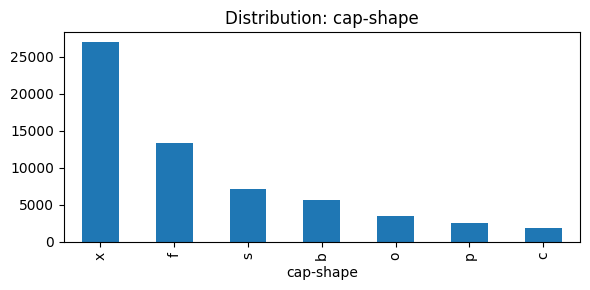

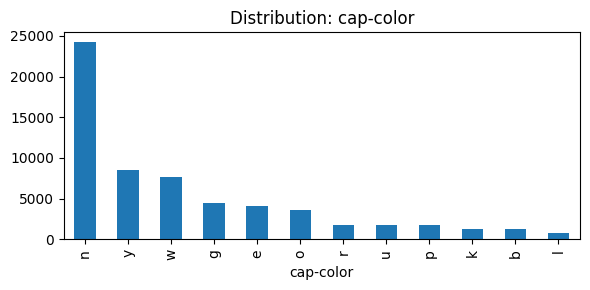

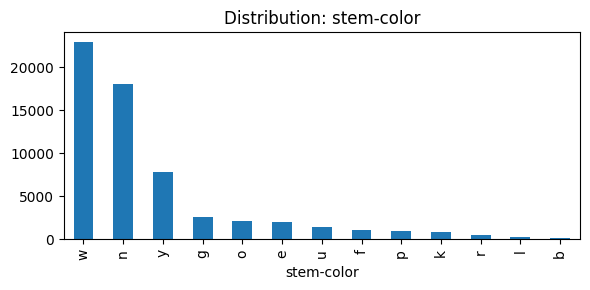

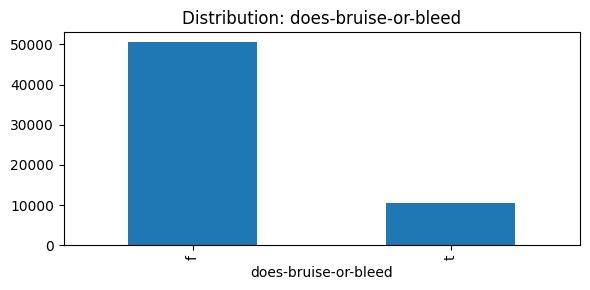

In [11]:
# Example: cap-shape, cap-color, stem-color, does-bruise-or-bleed
plot_cols = ['cap-shape', 'cap-color', 'stem-color', 'does-bruise-or-bleed']
for c in plot_cols:
    if c in df.columns:
        plt.figure(figsize=(6,3))
        df[c].value_counts().plot(kind='bar')
        plt.title(f'Distribution: {c}')
        plt.tight_layout()
        plt.show()

## 9. Prepare features & target

In [12]:
X = df.drop('class', axis=1)
y = df['class']

# Check shapes
X.shape, y.shape

((61069, 12), (61069,))

## 10. Encode categorical features (One-Hot for tree models)

In [14]:
cat_cols = X.select_dtypes(include='object').columns.tolist()

ct = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

# Fit-transform
X_encoded = ct.fit_transform(X)

print('Encoded shape:', X_encoded.shape)

Encoded shape: (61069, 72)


**Note:** `sparse=False` will return a dense array. If memory is a concern, switch to `sparse=True` and use sparse-aware models or convert to sparse matrices.

## 11. Train-test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print('Train shape:', X_train.shape)
print('Test shape :', X_test.shape)

Train shape: (48855, 72)
Test shape : (12214, 72)


## 12. Baseline: Decision Tree

In [16]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print('Decision Tree Accuracy:', round(accuracy_score(y_test, y_pred), 4))
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))

Decision Tree Accuracy: 0.9894

Classification Report:
               precision    recall  f1-score   support

           e       0.99      0.99      0.99      5436
           p       0.99      0.99      0.99      6778

    accuracy                           0.99     12214
   macro avg       0.99      0.99      0.99     12214
weighted avg       0.99      0.99      0.99     12214


Confusion Matrix:
 [[5363   73]
 [  57 6721]]


## 13. Final Model: Random Forest

In [17]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print('Random Forest Accuracy:', round(accuracy_score(y_test, y_pred_rf), 4))
print('\nClassification Report:\n', classification_report(y_test, y_pred_rf))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred_rf))

Random Forest Accuracy: 0.9975

Classification Report:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00      5436
           p       1.00      1.00      1.00      6778

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214


Confusion Matrix:
 [[5420   16]
 [  14 6764]]


## 14. Feature importance (top 20)

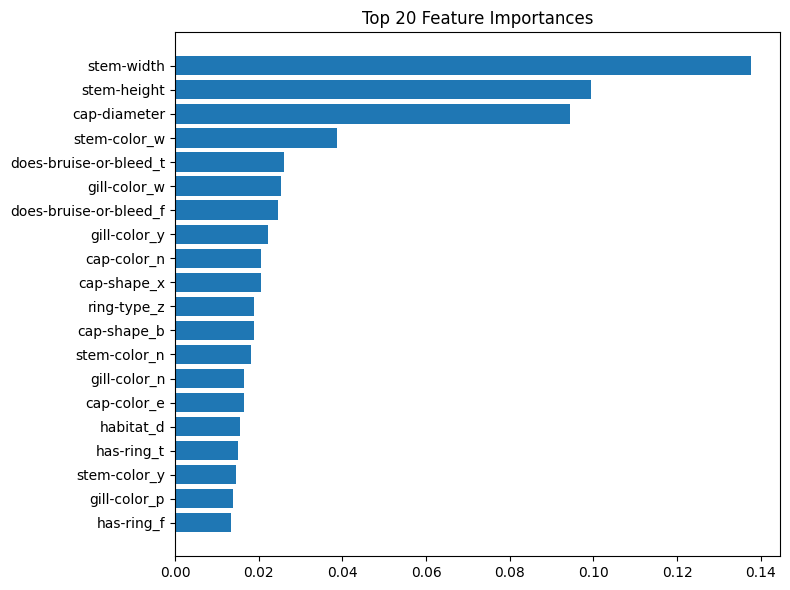

has-ring_f : 0.0134
gill-color_p : 0.0138
stem-color_y : 0.0145
has-ring_t : 0.015
habitat_d : 0.0156
cap-color_e : 0.0164
gill-color_n : 0.0164
stem-color_n : 0.0183
cap-shape_b : 0.0188
ring-type_z : 0.019
cap-shape_x : 0.0205
cap-color_n : 0.0205
gill-color_y : 0.0223
does-bruise-or-bleed_f : 0.0245
gill-color_w : 0.0254
does-bruise-or-bleed_t : 0.026
stem-color_w : 0.0387
cap-diameter : 0.0944
stem-height : 0.0995
stem-width : 0.1377


In [18]:
# Get OHE feature names
ohe_feature_names = ct.named_transformers_['encoder'].get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([ohe_feature_names, num_cols])

importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(8,6))
plt.barh(np.arange(len(indices)), importances[indices])
plt.yticks(np.arange(len(indices)), all_feature_names[indices])
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

# Print list form
for i in indices:
    print(all_feature_names[i], ':', round(importances[i], 4))

## 🔍 Key Insights from Feature Importance Plot

### **1️⃣ Numeric features dominate — especially stem-width, stem-height, and cap-diameter**
- **stem-width** is the strongest feature (~0.14 importance).
- **stem-height** and **cap-diameter** follow closely behind.

👉 *Mushroom size directly influences toxicity prediction — bigger/smaller shapes correlate with edible or poisonous types.*



### **2️⃣ Color-based features also matter**
Examples:
- `stem-color_w`
- `gill-color_w`
- `cap-color_n`

Color patterns help the model distinguish between different mushroom species.

👉 *Certain color combinations may be more common in poisonous mushrooms.*



### **3️⃣ Bruising behavior is a strong biological indicator**
Important features:
- `does-bruise-or-bleed_t`
- `does-bruise-or-bleed_f`

👉 *Whether a mushroom bruises or bleeds when touched is often linked to its toxicity.*


### **4️⃣ Ring-type and cap-shape features contribute moderately**
Examples:
- `ring-type_z`
- `cap-shape_x`, `cap-shape_b`

👉 *Structural differences (cap shape, ring type) provide extra clues to the model.*


### **5️⃣ Habitat and season have lower importance**
- These features don’t strongly influence predictions but still add small helpful signals.


## 15. Save encoder & model

In [20]:
with open('mushroom_encoder.pkl', 'wb') as f:
    pickle.dump(ct, f)

with open('mushroom_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

print('Saved mushroom_encoder.pkl and mushroom_model.pkl')

Saved mushroom_encoder.pkl and mushroom_model.pkl


## 16. Prediction helper function

In [21]:
# Load (example) and predict for a single sample
with open('mushroom_encoder.pkl', 'rb') as f:
    loaded_ct = pickle.load(f)
with open('mushroom_model.pkl', 'rb') as f:
    loaded_rf = pickle.load(f)


def predict_mushroom_sample(sample_dict):
    sample_df = pd.DataFrame([sample_dict])
    encoded = loaded_ct.transform(sample_df)
    pred = loaded_rf.predict(encoded)[0]
    return 'Poisonous (p)' if pred == 'p' else 'Edible (e)'

In [22]:
# Example usage (adjust features to the columns that remain):
example = {
    'cap-diameter': 5.2,
    'cap-shape': 'x',
    'cap-color': 'n',
    'does-bruise-or-bleed': 't',
    'gill-color': 'w',
    'stem-height': 8.0,
    'stem-width': 1.2,
    'stem-color': 'w',
    'has-ring': 't',
    'ring-type': 'z',
    'habitat': 'd',
    'season': 's'
}

print('Prediction for example:', predict_mushroom_sample(example))

Prediction for example: Poisonous (p)


## 17. Project Summary

- Dataset size after dropping high-missing columns: <replace with final shape>
- Target: 'class' (p = poisonous, e = edible)
- Preprocessing: Dropped columns with >40% missing values, handled categorical features with OneHotEncoding, preserved numeric columns.
- Models: Decision Tree baseline (accuracy ~0.9894), Random Forest final model (accuracy ~0.9975).
- Key features: stem-width, stem-height, cap-diameter, stem-color, does-bruise-or-bleed, various color categories.
- Model artifacts saved: mushroom_encoder.pkl, mushroom_model.pkl
- Next steps: Hyperparameter tuning (GridSearchCV), cross-validation for more robust estimate, build a small Flask app or Streamlit demo for interactive predictions.

## 18. Tips & Best Practices

* Always inspect missing values and their patterns before blind imputation.
* If a column has >30-40% missing, consider whether dropping is better than imputation.
* For tree-based models, One-Hot encoding works fine, but if the number of categories explodes, consider target encoding or embedding.
* Use `Stratify` in train/test split for imbalanced classification.
* Save both encoder and model; you need both to preprocess new data.